# SQS elastic constants

This notebook demonstrates the functionality of job classes designed to calculate chemistry-dependent elastic data by averaging over one or more special-quasirandom structures.

In [1]:
from pyiron import Project
import pyiron_contrib
import pyiron_mpie
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [3]:
pr = Project('scratch')
# pr.remove_jobs_silently(recursive=True)
# pr

# Setup reference jobs

The input to these SQS elastic job classes is quite minimal, rather run parameters are passed in in the form of reference jobs.

Of special importance are the `SQSJob` type reference, which handles the generation of special quasirandom structures, and `ElasticMatrixJob`, which computes the elastic constants. Thankfully, these jobs already existed, so the development of the new SQS elastic jobs was just a matter of stringing them together. 

An advantage of this setup is that any new improvements to the functionality of these underlying jobs is included in the SQS elastic jobs without having to modify SQS elastic code specifically, since they appear simply as references. However, the flip side of the coin is that the functionality of these jobs was not exhaustively tested. Results are very reasonable for the FCC Al system tested, but keep your physicist hat on when running the code and ensure that your results are coming out sensibly.

The final and most basic reference is the model which will interpret atomic positions to produce forces and energies. Here we'll use Lammps, but, if you have a lot of processor power lying around, there should be no barrier to using a quantum mechanical code like Vasp instead.

Here, we'll scale a lot of the input parameters way back so the calculations run faster.

In [4]:
lammps = pr.create_job(pr.job_type.Lammps, 'hr')
lammps.structure = pr.create_ase_bulk('Al', cubic=True).repeat(5)
lammps.structure[:3] = 'Mg'
lammps.potential = 'Al_Mg_eam_fs'
# lammps.calc_minimize(pressure=0)

sqs = pr.create_job(pr.job_type.SQSJob, 'sr')
sqs.input.iterations = 100
sqs.input.weights = None
sqs.input.n_output_structures = 2  
# SQSJob Bug?: only 1 structure is being used if mole_factions are given,
# but it seems to be OK if I rely on the structure composition directly

elastic = pr.create_job(pr.job_type.ElasticMatrixJob, 'er')
elastic.input['num_of_points'] = 3
elastic.input['fit_order'] = 2
elastic.input['eps_range'] = 0.005
elastic.input['relax_atoms'] = False
elastic.input['sqrt_eta'] = False
# TODO: Get an updated version of ElasticMatrixJob that is public (rather than living
#  on the private repo pyiron_mpie) and uses a more modern input format like InputList

# Option 1: A single composition

If we're interested in a single chemical composition, we can run the calculation for that directly and look at the statistical properties of the output.

In [5]:
# sqs.input.mole_fractions = {'Al': 0.9, 'Mg': 0.1}  
# ^^ Molar fractions are necessary if the structure isn't already at the right composition

sqs_elastic = pr.create_job(pr.job_type.SQSElasticConstants, 'single')
sqs_elastic.ref_ham = lammps
sqs_elastic.ref_sqs = sqs
sqs_elastic.ref_elastic = elastic
sqs_elastic.run()

The job single_ham_ref was saved and received the ID: 3
The job single_sqs_ref was saved and received the ID: 4
The job single_el_job was saved and received the ID: 5
The job single was saved and received the ID: 6
The job single_sqs was saved and received the ID: 7
Threads used: 1
The job single_min was saved and received the ID: 8
The job struct_0 was saved and received the ID: 9
The job struct_1 was saved and received the ID: 10
The job single_elastic was saved and received the ID: 11
The job struct_0 was saved and received the ID: 12
The job s_e_0 was saved and received the ID: 13
The job s_01_e_m0_00500 was saved and received the ID: 14
The job s_01_e_0_00500 was saved and received the ID: 15
The job s_25_e_m0_00500 was saved and received the ID: 16
The job s_25_e_0_00500 was saved and received the ID: 17
The job s_24_e_m0_00500 was saved and received the ID: 18
The job s_24_e_0_00500 was saved and received the ID: 19
The job s_28_e_m0_00500 was saved and received the ID: 20
The j

In [19]:
sqs_elastic.output.elastic_matrices.sem

array([[9.17672847e-02, 8.08648242e-03, 2.07140712e-02, 3.84220548e-03,
        3.36861848e-02, 1.99267502e-02],
       [8.08648242e-03, 4.68169635e-03, 1.65052849e+01, 3.32070452e-02,
        4.19181901e-03, 4.61873116e-02],
       [2.07140712e-02, 1.65052849e+01, 7.01556049e-04, 3.30240255e-02,
        3.37084149e-02, 4.97610200e-02],
       [3.84220548e-03, 3.32070452e-02, 3.30240255e-02, 9.49023087e-04,
        7.25392761e-04, 9.11309846e-03],
       [3.36861848e-02, 4.19181901e-03, 3.37084149e-02, 7.25392761e-04,
        2.10281287e-03, 8.88339908e-03],
       [1.99267502e-02, 4.61873116e-02, 4.97610200e-02, 9.11309846e-03,
        8.88339908e-03, 4.42377734e-04]])

In [35]:
sqs_elastic_loaded = pr.load(sqs_elastic.job_name)

In [36]:
#Can look at statistics over the SQS structures: .array, .mean, .std, .sem
sqs_elastic_loaded.output.elastic_matrices.mean  

array([[ 1.10442578e+02,  6.29871697e+01,  6.30088695e+01,
         7.68441095e-03,  6.73723696e-02,  1.01832837e-01],
       [ 6.29871697e+01,  1.10227012e+02,  9.59789912e+01,
         6.64140905e-02,  8.38363803e-03,  5.17004040e-02],
       [ 6.30088695e+01,  9.59789912e+01,  1.10210579e+02,
         6.60480511e-02,  6.74168299e-02, -8.37842978e-02],
       [ 7.68441095e-03,  6.64140905e-02,  6.60480511e-02,
         3.30522086e+01,  3.68753347e-02,  1.82261969e-02],
       [ 6.73723696e-02,  8.38363803e-03,  6.74168299e-02,
         3.68753347e-02,  3.30541235e+01,  1.77667982e-02],
       [ 1.01832837e-01,  5.17004040e-02, -8.37842978e-02,
         1.82261969e-02,  1.77667982e-02,  3.30540069e+01]])

In [37]:
# TODO: Loading somehow has a bug for the pressures?
sqs_elastic_loaded.output.residual_pressures

/Users/huber/Liam/pyiron/pyiron_repos/pyiron_base/pyiron_base/generic/inputlist.py:287: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(self._store)


[array([[-3.18759172e-07,  1.61667101e-04, -4.02343767e-17],
       [ 1.61667101e-04,  1.16137737e-08, -9.23110716e-16],
       [-4.02343767e-17, -9.23110716e-16,  2.84969308e-09]])
 array([[ 4.87181378e-07,  4.56519745e-04,  2.80804191e-04],
       [ 4.56519745e-04, -2.02958980e-07, -4.19985640e-04],
       [ 2.80804191e-04, -4.19985640e-04, -6.96217218e-07]])
 None None None]

# Option 2: Scan various compositions

Alternatively, we might want to look for chemical trends across multiple different compositions. This is also possible. 

In [8]:
sqs_elastic_ref = pr.create_job(pr.job_type.SQSElasticConstants, 'se')
sqs_elastic_ref.ref_ham = lammps
sqs_elastic_ref.ref_sqs = sqs
sqs_elastic_ref.ref_elastic = elastic

job = sqs_elastic_ref.create_job(pr.job_type.SQSElasticConstantsList, 'scan')
job.input.compositions = [
    {'Al': 1., 'Mg': 0.},
    {'Al': 0.975, 'Mg': 0.025},
    {'Al': 0.95, 'Mg': 0.05}
]
job.run()
# TODO: Test submitting a job on the server.

The job se_ham_ref was saved and received the ID: 84
The job se_sqs_ref was saved and received the ID: 85
The job se_el_job was saved and received the ID: 86
The job scan was saved and received the ID: 87
The job Al10_Mg00_ham_ref was saved and received the ID: 88
The job Al10_Mg00_sqs_ref was saved and received the ID: 89
The job Al10_Mg00_el_job was saved and received the ID: 90
The job Al10_Mg00 was saved and received the ID: 91
The job Al10_Mg00_sqs was saved and received the ID: 92
Threads used: 1
The job Al10_Mg00_min was saved and received the ID: 93
The job struct_0 was saved and received the ID: 94
The job Al10_Mg00_elastic was saved and received the ID: 95
The job struct_0 was saved and received the ID: 96
The job s_e_0 was saved and received the ID: 97
The job s_01_e_m0_00500 was saved and received the ID: 98
The job s_01_e_0_00500 was saved and received the ID: 99
The job s_08_e_m0_00500 was saved and received the ID: 100
The job s_08_e_0_00500 was saved and received the ID

2020-10-16 10:09:51,212 - pyiron_log - WARNING - Job 'Al10_Mg00_ham_ref' does not exist and cannot be loaded
2020-10-16 10:09:51,233 - pyiron_log - WARNING - Job 'Al10_Mg00_sqs_ref' does not exist and cannot be loaded
2020-10-16 10:09:51,249 - pyiron_log - WARNING - Job 'Al10_Mg00_el_job' does not exist and cannot be loaded
2020-10-16 10:09:51,625 - pyiron_log - WARNING - Job 'Al0975_Mg0025_ham_ref' does not exist and cannot be loaded
2020-10-16 10:09:51,651 - pyiron_log - WARNING - Job 'Al0975_Mg0025_sqs_ref' does not exist and cannot be loaded
2020-10-16 10:09:51,719 - pyiron_log - WARNING - Job 'Al0975_Mg0025_el_job' does not exist and cannot be loaded
2020-10-16 10:09:52,102 - pyiron_log - WARNING - Job 'Al095_Mg005_ham_ref' does not exist and cannot be loaded
2020-10-16 10:09:52,116 - pyiron_log - WARNING - Job 'Al095_Mg005_sqs_ref' does not exist and cannot be loaded
2020-10-16 10:09:52,172 - pyiron_log - WARNING - Job 'Al095_Mg005_el_job' does not exist and cannot be loaded
2020

In [20]:
job.output.elastic_matrices

[[[[ 1.10150925e+02  6.17055177e+01  6.17055177e+01  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 6.17055177e+01  1.10150925e+02  6.17055177e+01  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 6.17055177e+01  6.17055177e+01  1.10150925e+02  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.27021072e+01
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
     3.27021072e+01  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
     0.00000000e+00  3.27021072e+01]]]


 [[[ 1.10145354e+02  6.67336688e+01  6.68331975e+01 -3.26289097e-02
     5.55636637e-02  1.12648634e-01]
   [ 6.67336688e+01  1.10400668e+02  6.69305034e+01  5.40205140e-02
    -2.87805731e-02  1.52497690e-01]
   [ 6.68331975e+01  6.69305034e+01  1.10737764e+02  5.63439069e-02
     9.23823102e-02  2.32056762e-03]
   [-3.26289097e-02  5.40205140e-02  5.63439069e-02

Since these jobs might be expensive, it is also important that we can load the job from HDF an look at output later. For instance, below we use convenient helper methods to look at the trends and interpolate a value that was not calculated.

In [21]:
loaded = pr.load(job.job_name)

<AxesSubplot:xlabel='Al Atomic fraction', ylabel='Elastic constants (GPa)'>

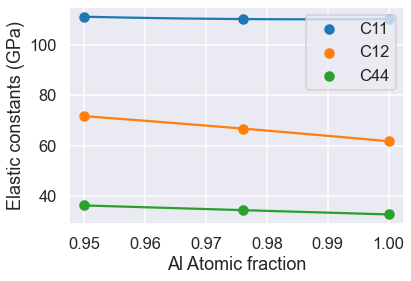

In [24]:
loaded.plot('Al')

In [28]:
loaded.get_C12_poly('Mg')(0.033333)

68.56275894929516